# Análisis Exploratorio de Datos (EDA) - Estadísticas de jugadores de la Premier League
**Objetivo:** Realizar un EDA estructurado integrando un dataset primario (Estadísticas sencillas de la EPL) con un dataset que posee estadísticas adicionales obtenido mediante web scraping (La puntuación de Sofascore entre otros).

###  Importaciones:

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import difflib

# Configurar el estilo de los gráficos
sns.set_theme(style="whitegrid")

## 1. Carga de datos y primera inspección
Cargar los datos para comprender su forma, tipos de datos y primeros registros.

In [101]:
# Cargar el dataset primario
df_std = pd.read_csv("Squad_PlayerStats__stats_standard.csv")

# Cargar el dataset extra (extraído de Sofascore)
df_sofa = pd.read_csv("estadisticas_premier.csv")

print(f"Forma del dataset base: {df_std.shape}")
print(f"Forma del dataset de Sofascore: {df_sofa.shape}")

display(df_std.head(3))
display(df_sofa.head(3))

Forma del dataset base: (574, 25)
Forma del dataset de Sofascore: (562, 9)


,Rk,Player,Nation,Pos,Squad,Age,Born,Playing Time_MP,Playing Time_Starts,Playing Time_Min,...,Performance_PK,Performance_PKatt,Performance_CrdY,Performance_CrdR,Per 90 Minutes_Gls,Per 90 Minutes_Ast,Per 90 Minutes_G+A,Per 90 Minutes_G-PK,Per 90 Minutes_G+A-PK,Matches
0,1,Max Aarons,eng ENG,DF,Bournemouth,24.0,2000.0,3,1,86,...,0,0,0,0,0.0,0.00,0.00,0.0,0.00,Matches
1,2,Joshua Acheampong,eng ENG,DF,Chelsea,18.0,2006.0,4,2,170,...,0,0,1,0,0.0,0.00,0.00,0.0,0.00,Matches
2,3,Tyler Adams,us USA,MF,Bournemouth,25.0,1999.0,28,21,1965,...,0,0,7,0,0.0,0.14,0.14,0.0,0.14,Matches


,equipo,nombre,goles,goles_esperados,regates_completados,entradas,asistencias,pases_precisos,puntuacion
0,Arsenal,Neto,0,NaN,0,0,0,61.11,7.85
1,Liverpool,Mohamed Salah,29,25.37,58,21,18,73.85,7.78
2,Chelsea,Cole Palmer,15,17.27,51,34,8,83.13,7.63


## 2. Evaluación de la calidad de los datos
Comprobación de valores nulos, duplicados e inconsistencias generales en ambos datasets.

In [102]:
# Comprobar valores nulos
print("--- Valores nulos en estadísticas base ---")
print(df_std.isnull().sum()[df_std.isnull().sum() > 0])

print("\n--- Valores nulos en estadísticas de Sofascore ---")
print(df_sofa.isnull().sum()[df_sofa.isnull().sum() > 0])

# Comprobar duplicados
print(f"\nDuplicados en base: {df_std.duplicated().sum()}")
print(f"Duplicados en Sofascore: {df_sofa.duplicated().sum()}")

--- Valores nulos en estadísticas base ---
Nation    1
Age       1
Born      1
dtype: int64

--- Valores nulos en estadísticas de Sofascore ---
goles_esperados    105
dtype: int64

Duplicados en base: 0
Duplicados en Sofascore: 0


## 3. Limpieza y preprocesamiento de datos
Solución de los problemas de calidad encontrados:
- Limpieza del formato de la columna `Nation` (ej. de 'eng ENG' a 'ENG').
- Manejo de goles esperados (`goles_esperados`) vacíos en Sofascore asumiendo 0.0 para jugadores sin acciones de ataque.
- Rellenar puntuaciones vacías de Sofascore con el valor mínimo.
- Eliminación de columnas irrelevantes.

In [103]:
# Limpiar la columna 'Nation' (ej., 'eng ENG' -> 'ENG')
# Usamos .str.split() que maneja automáticamente los valores vacíos (NaN) sin dar error
df_std['Nation'] = df_std['Nation'].str.split().str[-1]

# Rellenar los goles esperados vacíos en Sofascore con 0.0 (los jugadores que no tiran a puerta suelen tener xG nulo)
df_sofa['goles_esperados'] = df_sofa['goles_esperados'].fillna(0.0)

# Rellenar la puntuación vacía de Sofascore con el valor mínimo
df_sofa['puntuacion'] = df_sofa['puntuacion'].fillna(df_sofa['puntuacion'].min())

# Eliminar la columna de referencia 'Matches' del dataset estándar ya que no nos sirve aquí
if 'Matches' in df_std.columns:
    df_std = df_std.drop(columns=['Matches'])

print("Limpieza completada. Muestra de la columna 'Nation' limpia:")
print(df_std['Nation'].unique()[:10])

Limpieza completada. Muestra de la columna 'Nation' limpia:
['ENG' 'USA' 'CIV' 'NGA' 'ALG' 'NOR' 'SUI' 'NED' 'ARG' 'BRA']


## 4. Integración de datos enriquecidos
Fusión del dataset primario con el dataset extraído de Sofascore.

Añadir datos de Sofascore nos permite medir el rendimiento con métricas que no suelen venir por defecto (goles esperados, regates, precisión de pases y la puntuación general del algoritmo). 

Como a veces los nombres de los jugadores varían un poco dependiendo de la página (por ejemplo, 'Heung-min Son' frente a 'Son Heung-min'), usamos la librería `difflib` para emparejarlos de forma aproximada.

In [104]:
# Lista de nombres disponibles en el dataset extra (Sofascore)
sofa_names = df_sofa['nombre'].dropna().tolist()

# Creamos un diccionario para emparejar nombres que no coincidan exactamente usando fuzzy matching
mapping = {}
for name in df_std['Player']:
    if type(name) == str and name not in sofa_names:
        matches = difflib.get_close_matches(name, sofa_names, n=1, cutoff=0.7)
        if matches:
            mapping[name] = matches[0]

# Añadimos algunas excepciones manuales conocidas
manual_mappings = {
    'Jáder Durán': 'Jhon Durán',
    'Hwang Hee-chan': 'Hee-Chan Hwang',
    'Son Heung-min': 'Heung-min Son',
    'Igor': 'Igor Júlio',
    'Sávio': 'Savinho'
}
mapping.update(manual_mappings)

# Aplicamos el mapeo a una nueva columna
df_std['Player_mapped'] = df_std['Player'].apply(lambda x: mapping.get(x, x))

# Seleccionar solo las nuevas métricas avanzadas de Sofascore para la unión
cols_to_merge = ['nombre', 'goles_esperados', 'regates_completados', 'entradas', 'pases_precisos', 'puntuacion']
df_sofa_sub = df_sofa[cols_to_merge]

# Mergeamos los datasets
df_merged = pd.merge(df_std, df_sofa_sub, left_on='Player_mapped', right_on='nombre', how='left')
df_merged.drop(columns=['nombre', 'Player_mapped'], inplace=True) # Limpieza

# Unificación de posiciones múltiples
# Definimos los umbrales para clasificar a los jugadores híbridos
UMBRAL_GOLES = 10
UMBRAL_ASISTENCIAS = 5
UMBRAL_ENTRADAS = 20

# Asegurarnos de que 'entradas' se lee como número (por si acaso viene como texto desde el CSV)
df_merged['entradas'] = pd.to_numeric(df_merged['entradas'], errors='coerce').fillna(0)

def clasificar_posicion(row):
    pos = str(row['Pos'])
    
    # Si el jugador tiene múltiples posiciones (ej. 'MF, FW')
    if ',' in pos:
        if row['Performance_Gls'] >= UMBRAL_GOLES:
            return 'FW'  # Si marca mucho, es delantero
        elif row['Performance_Ast'] >= UMBRAL_ASISTENCIAS:
            return 'MF'  # Si asiste mucho, es mediocentro
        if row['entradas'] >= UMBRAL_ENTRADAS:
            return 'DF'  # Si hace muchas entradas, es defensa
        else:
            return 'MF'  # Por defecto, mediocentro
            
    # Si solo tiene una posición (ej. 'DF'), la dejamos intacta
    return pos

# Aplicamos la función fila por fila
df_merged['Pos'] = df_merged.apply(clasificar_posicion, axis=1)

# Mostrar el dataset enriquecido y limpio
print(f"Forma del dataset fusionado: {df_merged.shape}")
display(df_merged.head(3))

# Comprobar que las posiciones múltiples han desaparecido
print("\nPosiciones únicas resultantes:")
print(df_merged['Pos'].unique())

Forma del dataset fusionado: (574, 29)


,Rk,Player,Nation,Pos,Squad,Age,Born,Playing Time_MP,Playing Time_Starts,Playing Time_Min,...,Per 90 Minutes_Gls,Per 90 Minutes_Ast,Per 90 Minutes_G+A,Per 90 Minutes_G-PK,Per 90 Minutes_G+A-PK,goles_esperados,regates_completados,entradas,pases_precisos,puntuacion
0,1,Max Aarons,ENG,DF,Bournemouth,24.0,2000.0,3,1,86,...,0.0,0.00,0.00,0.0,0.00,0.00,0,2,80.39,6.80
1,2,Joshua Acheampong,ENG,DF,Chelsea,18.0,2006.0,4,2,170,...,0.0,0.00,0.00,0.0,0.00,0.22,1,2,83.74,6.53
2,3,Tyler Adams,USA,MF,Bournemouth,25.0,1999.0,28,21,1965,...,0.0,0.14,0.14,0.0,0.14,1.59,4,83,84.94,6.85



Posiciones únicas resultantes:
<StringArray>
['DF', 'MF', 'GK', 'FW']
Length: 4, dtype: str


## 5. Análisis univariante
Exploración de la distribución de las principales variables individuales (edad, minutos jugados y puntuación de Sofascore).

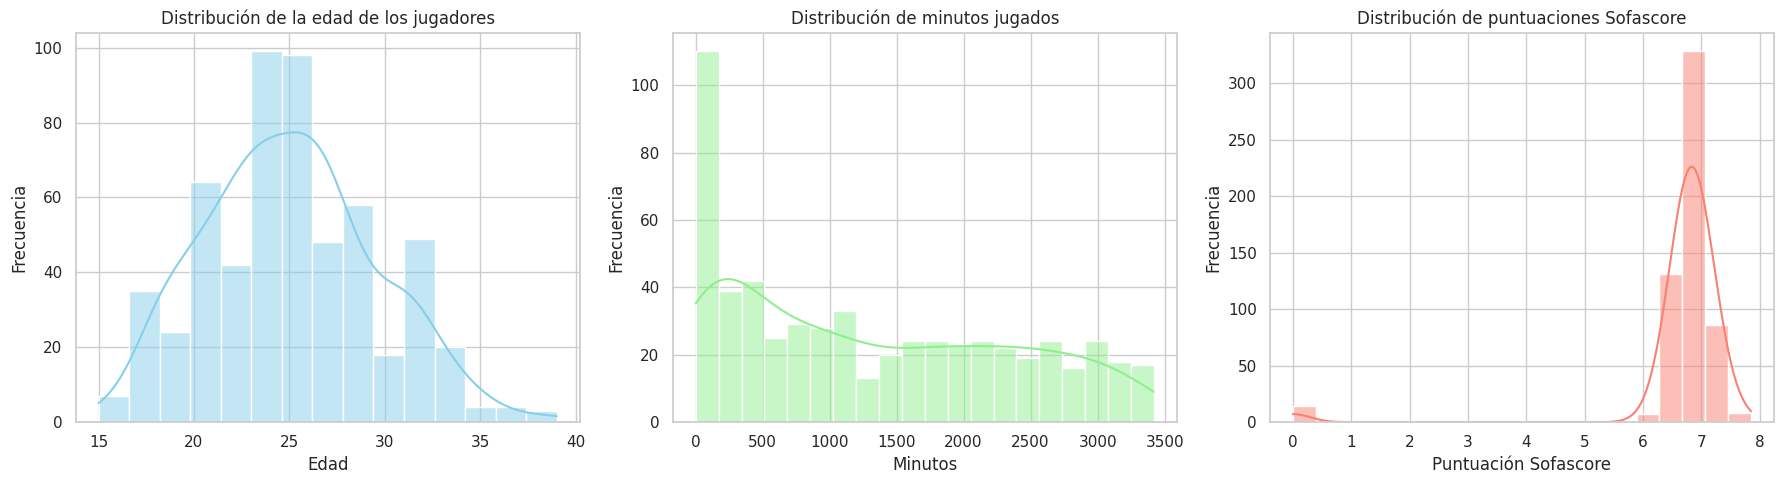

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribución de la edad
sns.histplot(df_merged['Age'].dropna(), bins=15, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribución de la edad de los jugadores')
axes[0].set_xlabel('Edad')
axes[0].set_ylabel('Frecuencia')

# Distribución de minutos jugados
sns.histplot(df_merged['Playing Time_Min'].dropna(), bins=20, kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('Distribución de minutos jugados')
axes[1].set_xlabel('Minutos')
axes[1].set_ylabel('Frecuencia')

# Distribución de la puntuación de Sofascore (Variable Enriquecida)
sns.histplot(df_merged['puntuacion'].dropna(), bins=20, kde=True, ax=axes[2], color='salmon')
axes[2].set_title('Distribución de puntuaciones Sofascore')
axes[2].set_xlabel('Puntuación Sofascore')
axes[2].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

## 6. Análisis bivariante / multivariante
Análisis de las relaciones entre las variables estándar y las extras para encontrar patrones profundos.

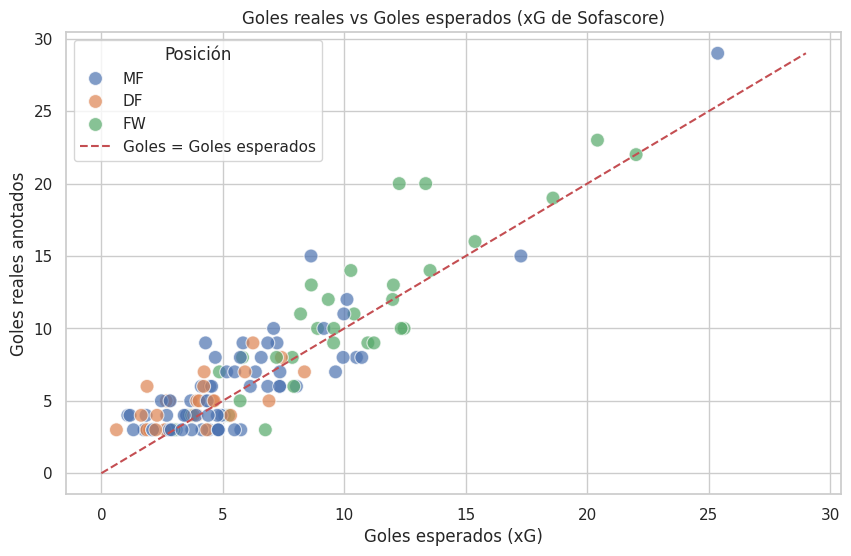

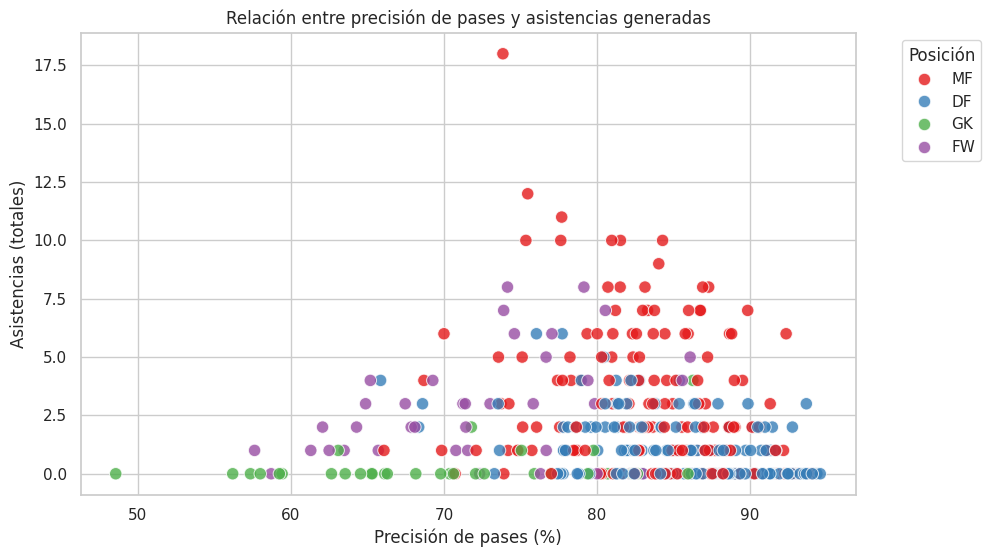

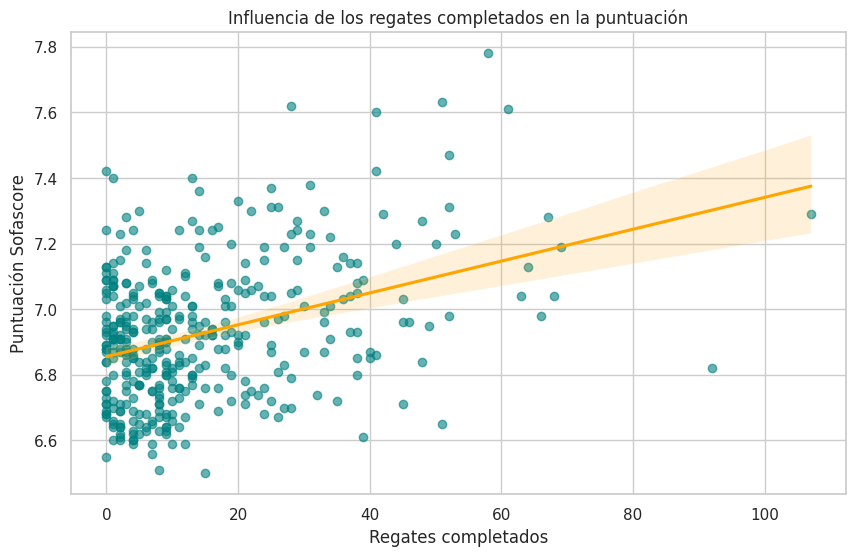

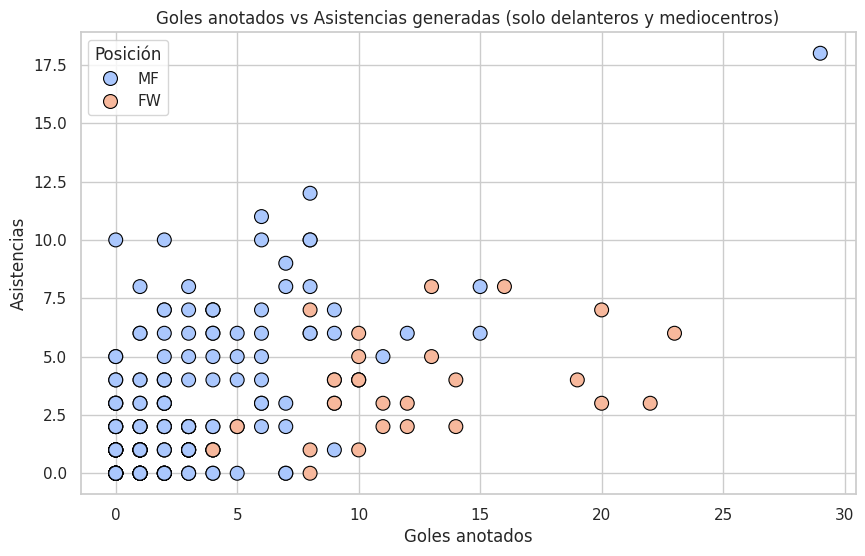

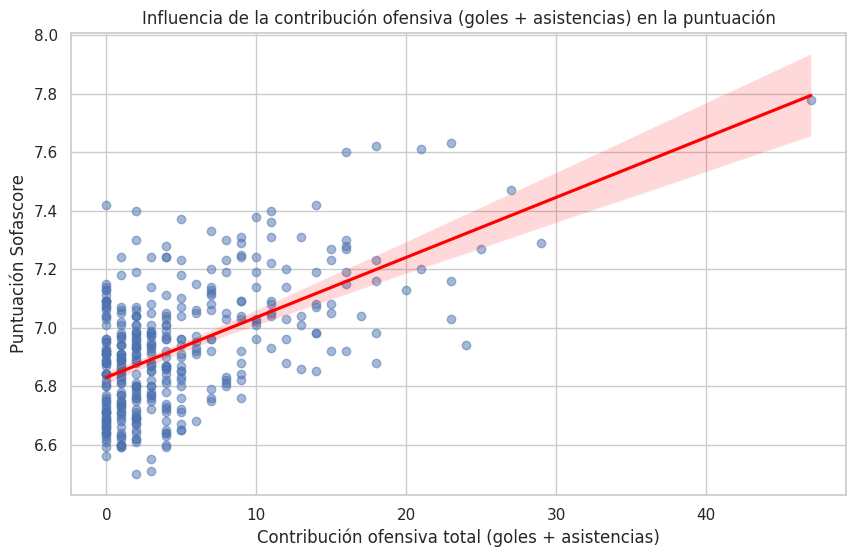

In [106]:
# 1. Primero creamos la nueva columna (Goles + Asistencias)
df_merged['Contribucion_Ofensiva'] = df_merged['Performance_Gls'] + df_merged['Performance_Ast']

# Filtramos jugadores con más de 500 minutos para evitar distorsiones estadísticas
regulars = df_merged[df_merged['Playing Time_Min'] > 500]

# Gráfico 1: Goles Reales vs Goles Esperados (xG) - Filtrado por los delanteros y mediocentros con > 2 goles
attackers = df_merged[df_merged['Performance_Gls'] > 2]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=attackers, x='goles_esperados', y='Performance_Gls', hue='Pos', s=100, alpha=0.7)

# Añadimos una línea de referencia y=x que representa cumplir exactamente con las expectativas
max_val = max(attackers['Performance_Gls'].max(), attackers['goles_esperados'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Goles = Goles esperados')

plt.title('Goles reales vs Goles esperados (xG de Sofascore)')
plt.xlabel('Goles esperados (xG)')
plt.ylabel('Goles reales anotados')
plt.legend(title='Posición')
plt.show()

# Gráfico 2: Asistencias vs Precisión de pases
plt.figure(figsize=(10, 6))
sns.scatterplot(data=regulars, x='pases_precisos', y='Performance_Ast', hue='Pos', palette='Set1', s=80, alpha=0.8)
plt.title('Relación entre precisión de pases y asistencias generadas')
plt.xlabel('Precisión de pases (%)')
plt.ylabel('Asistencias (totales)')
plt.legend(title='Posición', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Gráfico 3: Regates completados vs Puntuación Sofascore
plt.figure(figsize=(10, 6))
# Usamos regplot para ver la línea de tendencia clara entre regatear y puntuar bien
sns.regplot(data=regulars, x='regates_completados', y='puntuacion', 
            scatter_kws={'alpha':0.6, 'color':'teal'}, line_kws={'color':'orange'})
plt.title('Influencia de los regates completados en la puntuación')
plt.xlabel('Regates completados')
plt.ylabel('Puntuación Sofascore')
plt.show()

# Gráfico 4: Goles vs Asistencias (Solo delanteros y mediocentros)
# Filtramos para quedarnos solo con posiciones que contengan FW (Forward) o MF (Midfielder)
fw_mf = regulars[regulars['Pos'].fillna('').str.contains('FW|MF')]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=fw_mf, x='Performance_Gls', y='Performance_Ast', hue='Pos', palette='coolwarm', s=100, edgecolor='black')
plt.title('Goles anotados vs Asistencias generadas (solo delanteros y mediocentros)')
plt.xlabel('Goles anotados')
plt.ylabel('Asistencias')
plt.legend(title='Posición')
plt.show()

# Gráfico 5: Influencia de goles y asistencias en la puntuación de Sofascore
plt.figure(figsize=(10, 6))
sns.regplot(data=regulars, x='Contribucion_Ofensiva', y='puntuacion', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Influencia de la contribución ofensiva (goles + asistencias) en la puntuación')
plt.xlabel('Contribución ofensiva total (goles + asistencias)')
plt.ylabel('Puntuación Sofascore')
plt.show()

## 7. Análisis de Premios y Equipo de la Temporada (TOTS)

A continuación, compararemos nuestras estadísticas con los premios oficiales entregados al final de la temporada de la Premier League. Veremos si los datos respaldan numéricamente a los ganadores de los distintos galardones individuales y la formación del 11 ideal.

/tmp/ipykernel_1027/3756116533.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=regulars, x='TOTS', y='puntuacion', palette=['gold', 'lightgrey'])


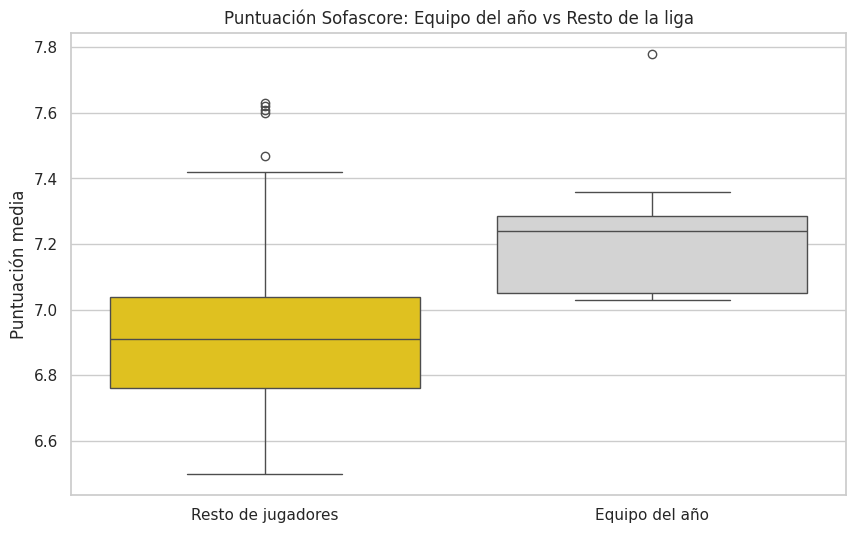

In [107]:
# 1. Etiquetar a los jugadores del equipo del año (TOTS)
tots_keywords = ['Salah', 'van Dijk', 'Gravenberch', 'Mac Allister', 'Saliba', 
                 'Gabriel Mag', 'Declan Rice', 'Matz Sels', 'Chris Wood', 'Isak', 'Kerkez']

def es_tots(nombre):
    for kw in tots_keywords:
        if kw in str(nombre): 
            return 'Equipo del año'
    return 'Resto de jugadores'

df_merged['TOTS'] = df_merged['Player'].apply(es_tots)

# Gráfico 1: Puntuación Sofascore (TOTS vs Resto)
plt.figure(figsize=(10, 6))
# Filtramos de nuevo para jugadores regulares
regulars = df_merged[df_merged['Playing Time_Min'] > 500]

sns.boxplot(data=regulars, x='TOTS', y='puntuacion', palette=['gold', 'lightgrey'])
plt.title('Puntuación Sofascore: Equipo del año vs Resto de la liga')
plt.ylabel('Puntuación media')
plt.xlabel('')
plt.show()

/tmp/ipykernel_1027/193727149.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_scorers, x='Performance_Gls', y='Player', ax=axes[0],
/tmp/ipykernel_1027/193727149.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_assists, x='Performance_Ast', y='Player', ax=axes[1],


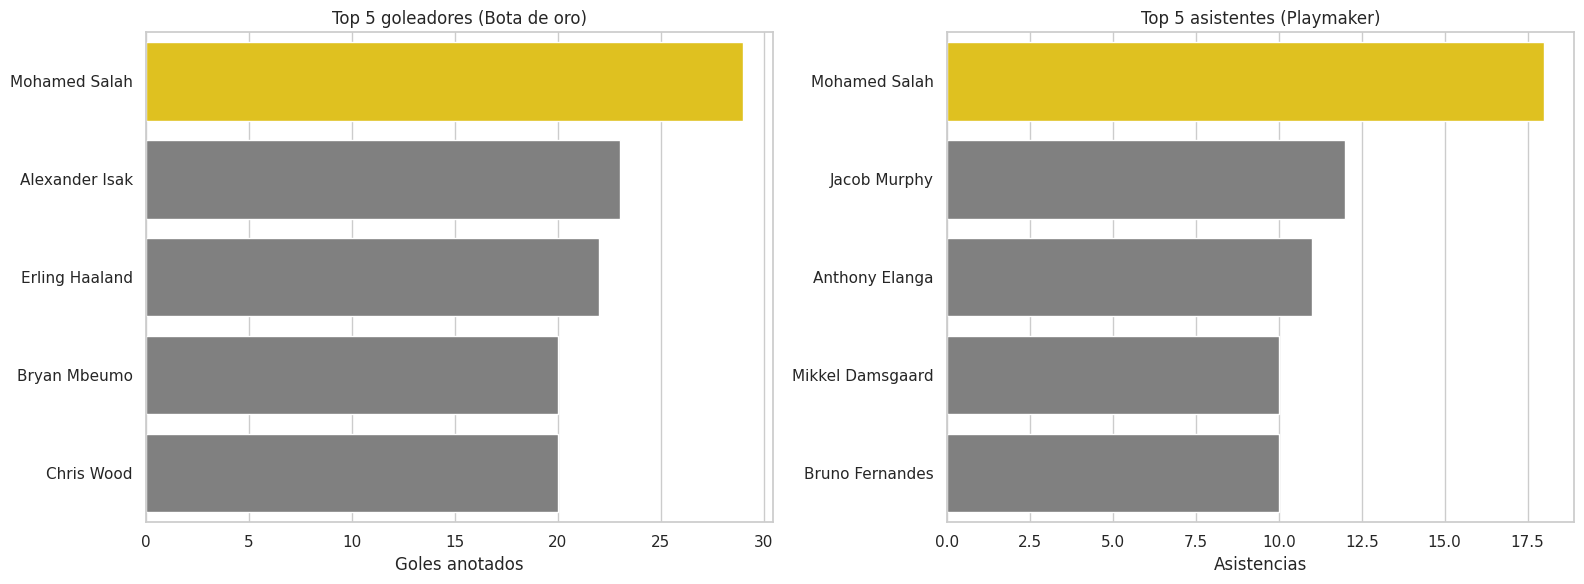

In [108]:
# Gráfico 2: Bota de oro y el Playmaker (creador de juego) (Goles y Asistencias)
# Obtenemos los 5 máximos goleadores y asistentes
top_scorers = df_merged.nlargest(5, 'Performance_Gls')
top_assists = df_merged.nlargest(5, 'Performance_Ast')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subgráfico de goles
sns.barplot(data=top_scorers, x='Performance_Gls', y='Player', ax=axes[0], 
            palette=['gold' if 'Salah' in x else 'gray' for x in top_scorers['Player']])
axes[0].set_title('Top 5 goleadores (Bota de oro)')
axes[0].set_xlabel('Goles anotados')
axes[0].set_ylabel('')

# Subgráfico de asistencias
sns.barplot(data=top_assists, x='Performance_Ast', y='Player', ax=axes[1], 
            palette=['gold' if 'Salah' in x else 'gray' for x in top_assists['Player']])
axes[1].set_title('Top 5 asistentes (Playmaker)')
axes[1].set_xlabel('Asistencias')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

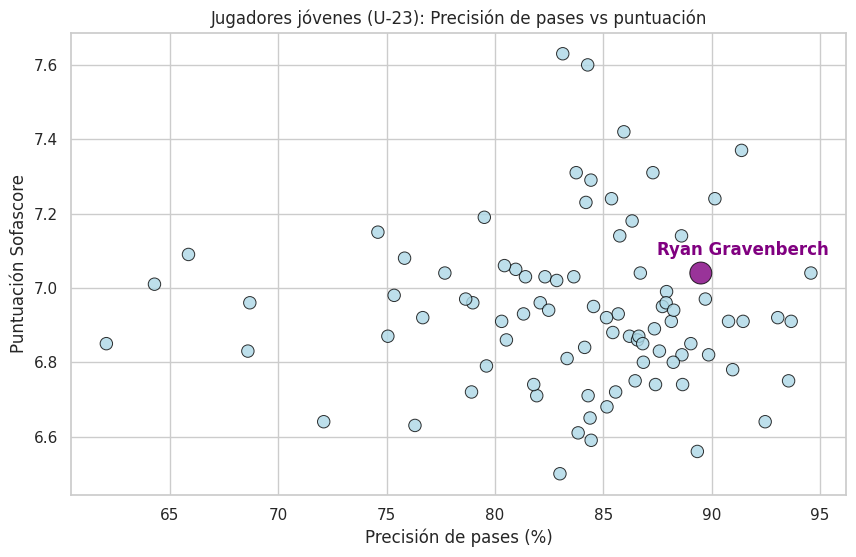

/tmp/ipykernel_1027/3174061886.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gks.nlargest(15, 'puntuacion'), x='puntuacion', y='Player',


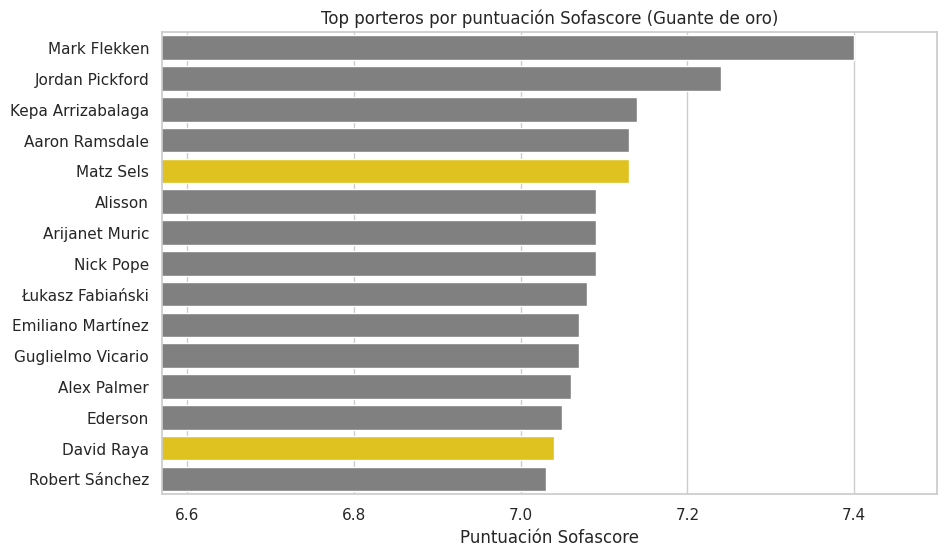

In [109]:
# Gráfico 3: Jugador joven de la temporada (Gravenberch)
# Filtramos jugadores de 23 años o menos con más de 1000 minutos
young_players = df_merged[(df_merged['Age'] <= 23) & (df_merged['Playing Time_Min'] > 1000)]

plt.figure(figsize=(10, 6))
# Destacamos a Gravenberch en el gráfico
colores = ['purple' if 'Gravenberch' in str(x) else 'lightblue' for x in young_players['Player']]
tamaños = [250 if 'Gravenberch' in str(x) else 80 for x in young_players['Player']]

sns.scatterplot(data=young_players, x='pases_precisos', y='puntuacion', 
                c=colores, s=tamaños, alpha=0.8, edgecolor='black')

# Etiqueta manual para Gravenberch
grav = young_players[young_players['Player'].str.contains('Gravenberch', na=False)]
if not grav.empty:
    plt.text(grav['pases_precisos'].values[0] - 2, grav['puntuacion'].values[0] + 0.05, 
             'Ryan Gravenberch', fontsize=12, weight='bold', color='purple')

plt.title('Jugadores jóvenes (U-23): Precisión de pases vs puntuación')
plt.xlabel('Precisión de pases (%)')
plt.ylabel('Puntuación Sofascore')
plt.show()

# Gráfico 4: Análisis de porteros (Guante de oro: Raya y Sels)
gks = df_merged[(df_merged['Pos'] == 'GK') & (df_merged['Playing Time_Min'] > 1000)].copy()

plt.figure(figsize=(10, 6))
sns.barplot(data=gks.nlargest(15, 'puntuacion'), x='puntuacion', y='Player', 
            palette=['gold' if ('Raya' in x or 'Sels' in x) else 'gray' for x in gks.nlargest(15, 'puntuacion')['Player']])
plt.title('Top porteros por puntuación Sofascore (Guante de oro)')
plt.xlabel('Puntuación Sofascore')
plt.ylabel('')
# Ajustamos los límites del eje X para que se vea mejor la diferencia
plt.xlim(gks['puntuacion'].min() - 0.2, gks['puntuacion'].max() + 0.1)
plt.show()

### El Equipo del Año (TOTS) Algorítmico vs El Real

Para comprobar cómo difiere el rendimiento puramente matemático de las votaciones reales, vamos a construir un 11 Ideal basado únicamente en la puntuación media de Sofascore. Para que la comparativa tenga sentido, usaremos una formación clásica 4-3-3 y estableceremos un filtro mínimo de 1.500 minutos jugados, evitando así que jugadores con muy pocos partidos pero notas altas distorsionen el resultado.

/tmp/ipykernel_1027/1009481912.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tots_algoritmo, x='puntuacion', y='Jugador_Pos', palette=colores_tots, edgecolor='black')


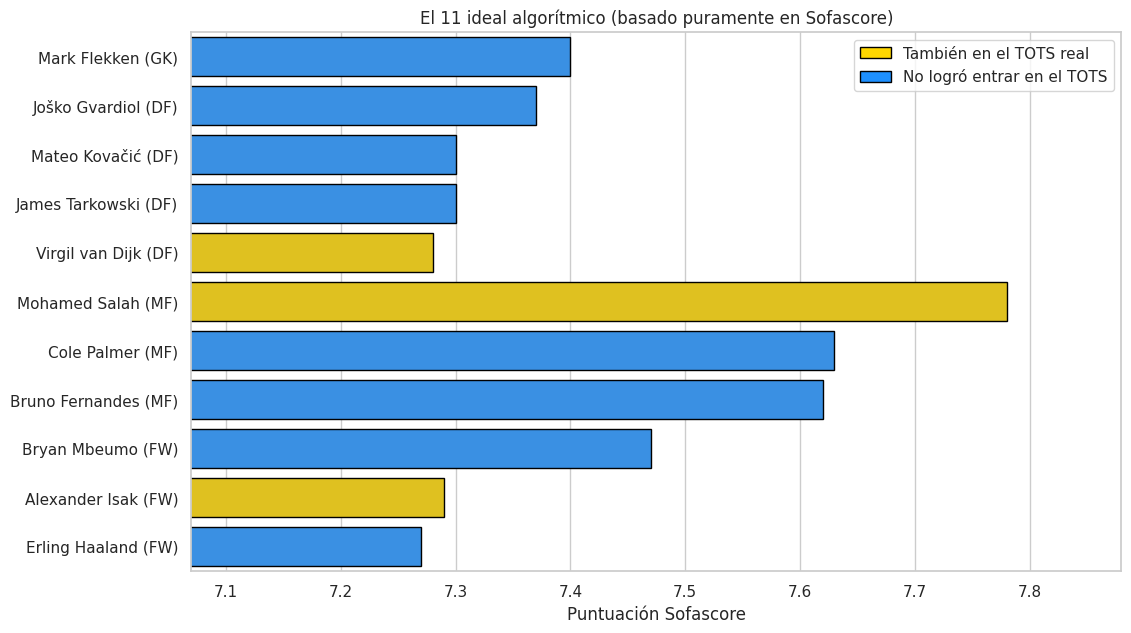


--- EL 11 IDEAL SEGÚN LOS DATOS ---


,Player,Squad,Pos,puntuacion,TOTS
183,Mark Flekken,Brentford,GK,7.40,Resto de jugadores
223,Joško Gvardiol,Manchester City,DF,7.37,Resto de jugadores
292,Mateo Kovačić,Manchester City,DF,7.30,Resto de jugadores
500,James Tarkowski,Everton,DF,7.30,Resto de jugadores
530,Virgil van Dijk,Liverpool,DF,7.28,Equipo del año
448,Mohamed Salah,Liverpool,MF,7.78,Equipo del año
407,Cole Palmer,Chelsea,MF,7.63,Resto de jugadores
180,Bruno Fernandes,Manchester Utd,MF,7.62,Resto de jugadores
340,Bryan Mbeumo,Brentford,FW,7.47,Resto de jugadores
252,Alexander Isak,Newcastle United,FW,7.29,Equipo del año



--- EL 11 IDEAL OFICIAL (REAL) ---


,Player,Squad,Pos,puntuacion
463,Matz Sels,Nottingham Forest,GK,7.13
530,Virgil van Dijk,Liverpool,DF,7.28
321,Gabriel Magalhães,Arsenal,DF,7.24
281,Milos Kerkez,Bournemouth,DF,7.06
449,William Saliba,Arsenal,DF,7.04
448,Mohamed Salah,Liverpool,MF,7.78
434,Declan Rice,Arsenal,MF,7.36
318,Alexis Mac Allister,Liverpool,MF,7.24
210,Ryan Gravenberch,Liverpool,MF,7.04
252,Alexander Isak,Newcastle United,FW,7.29


In [110]:
# 1. Filtramos jugadores con más de 1500 minutos para asegurar regularidad
jugadores_titulares = df_merged[df_merged['Playing Time_Min'] > 1500]

# 2. Seleccionamos a los mejores por posición basándonos puramente en su puntuacion
mejor_gk = jugadores_titulares[jugadores_titulares['Pos'] == 'GK'].nlargest(1, 'puntuacion')
mejores_df = jugadores_titulares[jugadores_titulares['Pos'] == 'DF'].nlargest(4, 'puntuacion')
mejores_mf = jugadores_titulares[jugadores_titulares['Pos'] == 'MF'].nlargest(3, 'puntuacion')
mejores_fw = jugadores_titulares[jugadores_titulares['Pos'] == 'FW'].nlargest(3, 'puntuacion')

# 3. Construimos el 11 ideal de los datos
tots_algoritmo = pd.concat([mejor_gk, mejores_df, mejores_mf, mejores_fw])

# Creamos una etiqueta que junte el nombre y la posición (Ej: "Mohamed Salah (FW)")
tots_algoritmo['Jugador_Pos'] = tots_algoritmo['Player'] + " (" + tots_algoritmo['Pos'] + ")"

# 4. Gráfico del 11 ideal algorítmico
plt.figure(figsize=(12, 7))

# Coloreamos de dorado si el jugador TAMBIÉN está en el equipo real, y azul si, pese a sus estadísticas, no logró entrar en el equipo del año
colores_tots = ['gold' if tots == 'Equipo del año' else 'dodgerblue' for tots in tots_algoritmo['TOTS']]

# Usamos la nueva etiqueta 'Jugador_Pos' en el eje Y
sns.barplot(data=tots_algoritmo, x='puntuacion', y='Jugador_Pos', palette=colores_tots, edgecolor='black')

plt.title('El 11 ideal algorítmico (basado puramente en Sofascore)')
plt.xlabel('Puntuación Sofascore')
plt.ylabel('')

# Leyenda manual para explicar los colores
from matplotlib.patches import Patch
leyenda = [Patch(facecolor='gold', label='También en el TOTS real', edgecolor='black'),
           Patch(facecolor='dodgerblue', label='No logró entrar en el TOTS', edgecolor='black')]
plt.legend(handles=leyenda, loc='upper right')

# Ajustamos el límite X para enfocar las diferencias de los mejores
plt.xlim(tots_algoritmo['puntuacion'].min() - 0.2, tots_algoritmo['puntuacion'].max() + 0.1)
plt.show()

# Mostrar la tabla final comparativa
print("\n--- EL 11 IDEAL SEGÚN LOS DATOS ---")
display(tots_algoritmo[['Player', 'Squad', 'Pos', 'puntuacion', 'TOTS']])


# 1. Filtramos para quedarnos ÚNICAMENTE con el 11 oficial (TOTS real)
tots_oficial = df_merged[df_merged['TOTS'] == 'Equipo del año'].copy()

# 2. Ordenamos por posición:
# Primero le decimos a Pandas el orden lógico de un campo de fútbol
orden_posiciones = ['GK', 'DF', 'MF', 'FW']
tots_oficial['Pos'] = pd.Categorical(tots_oficial['Pos'], categories=orden_posiciones, ordered=True)

# Ahora ordenamos: primero por posición (GK a FW) y luego por nota (de mayor a menor)
tots_oficial = tots_oficial.sort_values(by=['Pos', 'puntuacion'], ascending=[True, False])

# 3. Creamos la etiqueta conjunta de nombre + posición (Ej: "Mohamed Salah (FW)")
tots_oficial['Jugador_Pos'] = tots_oficial['Player'] + " (" + tots_oficial['Pos'].astype(str) + ")"

# Mostrar la tabla para revisión
print("\n--- EL 11 IDEAL OFICIAL (REAL) ---")
display(tots_oficial[['Player', 'Squad', 'Pos', 'puntuacion']])

## Conclusiones sobre los Premios Oficiales

Al repasar los gráficos, podemos sacar varias conclusiones sobre la relación entre estadísticas y premios:

**1. La justificación del Equipo del Año (TOTS):**
En el caso del Equipo del Año (TOTS), vemos que los jugadores elegidos tienen puntuaciones medias notablemente más altas que la mayoría. El diagrama de caja indica que la inmensa mayoría de ellos están situados por encima del percentil 75 del resto de futbolistas regulares.

**2. La temporada histórica de Mohamed Salah:**
Respecto a Mohamed Salah, lideró claramente tanto la lista de goles como la de asistencias, lo que explica por qué fue elegido jugador de la temporada. Pero su puntuación de Sofascore también confirma que fue el mejor jugador de la EPL y ayudó en gran parte a su equipo a ganar la liga ese año.

**3. Gravenberch, el faro del mediocampo (Mejor Jugador Joven):**
En el apartado del mejor jugador joven (sub-23), Ryan Gravenberch presenta números muy destacados. Combina una buena puntuación general con una precisión de pases, diferenciándose bastante del resto de jóvenes. Además también fue esencial para su equipo.

**4. Guante de Oro:**
Al analizar a los porteros (guante de oro), Matz Sels tiene una de las notas más altas según el algoritmo. David Raya, que también fue premiado, demuestra que el premio tradicional (basado en porterías a cero) suele reflejar no solo el trabajo del portero, sino el rendimiento general de toda la línea defensiva del equipo.

**5. Números puros contra el ojo humano (El equipo del año)**
Por último, al comparar el 11 algorítmico con el real, observamos que algunas grandes figuras como Salah coinciden sin problema. Sin embargo, el equipo basado en Sofascore también incluye a jugadores de equipos de mitad de tabla que tuvieron buenas estadísticas individuales aunque no fueran premiados, el hecho de que no aparezcan en la lista puede ser en parte por el equipo, un jugador que destaca mucho en un equipo perdedor hinchándose a goles realmente no puede lograr un gran impacto cuando el resto del equipo tampoco ayuda. Por otro lado no hay que obviar que lo que ven tus ojos dicen mucho más que las estadísticas, por ejemplo si comparamos estadísticas de jugadores históricos de hace años como Ronaldinho, Zidane e incluso Ronaldo Nazario estos pueden tener menos goles y asistencias que jugadores modernos que son peores que estos. El impacto de un jugador no lo muestran sus estadísticas.

## 8. Conclusiones y hallazgos clave

Tras realizar la limpieza, la fusión (Fuzzy Matching) y el análisis exploratorio cruzando las estadísticas tradicionales con las métricas avanzadas extraídas mediante Web Scraping de Sofascore, extraemos las siguientes conclusiones fundamentales:

**1. Diferenciación de perfiles y el valor del pase arriesgado**
Al analizar la relación entre la precisión de pases y las asistencias, descubrimos que los principales creadores de juego (*playmakers*) sacrifican precisión global a cambio de dar pases clave (filtrados, centros). Además, el cruce de Goles vs Asistencias nos permite segmentar perfectamente a los atacantes en "Finalizadores puros" y "Creadores". *Estas distinciones son vitales para el Scouting deportivo moderno.*

**2. Rendimiento Real vs Rendimiento Esperado (Goles vs xG)**
El uso de los Goles Esperados (`goles_esperados`) demuestra ser una métrica indispensable. Nuestro gráfico de dispersión revela claramente qué delanteros están en una racha de efectividad por encima de la media (anotando más de lo que sus ocasiones dictan) y cuáles están rindiendo por debajo de las expectativas algorítmicas, un hallazgo imposible de obtener usando únicamente el dataset estándar.

**3. ¿Qué premia realmente el algoritmo de valoración?**
Respecto al algoritmo de Sofascore, se observa una correlación clara y positiva con la suma total de goles y asistencias. No obstante, el sistema también valora de manera significativa otras acciones técnicas, como los regates completados, otorgando buenas notas a jugadores con un alto volumen de regates aunque no tengan participación directa en el marcador.

**4. Los Datos como jueces de los premios oficiales de la Premier League**
El cruce de nuestros datos con los galardones de la vida real nos dice lo siguiente:
* **El equipo del año (TOTS):** El análisis de cajas (*boxplot*) demuestra que los 11 elegidos pertenecen estadísticamente a la élite del la liga, situando su nota media muy por encima del percentil 75 del resto de la liga.
* **El Dominio de Salah:** Los gráficos de barras confirman la brutal temporada de Mohamed Salah, justificando sus premios al reinar con una ventaja aplastante tanto en la Bota de Oro como en el Creador de Juego.
* **El talento joven:** Ryan Gravenberch justifica su premio al Mejor Jugador Joven destacando en nuestro análisis multivariante como un "outlier" absoluto, combinando una nota altísima y una precisión de pases propia de un jugador mucho más veterano. 
* **El matiz del Guante de Oro:** Los datos de David Raya frente a Matz Sels nos enseñan una valiosa lección de analítica deportiva: los premios tradicionales basados en "Porterías a Cero" premian a todo el bloque defensivo del equipo, mientras que el análisis de puntuación técnica individual de Sofascore nos permite ver el rendimiento real del portero aislado de su defensa. Aunque no se debe pasar por alto el hecho de que los equipos de estos dos porteros fueron de los menos goleados de la liga.

**Clarificación importante:** Pese a que las estadísticas nos dicen una cosa los números no terminan de representar el impacto y calidad de un jugador, hay ejemplos a lo largo de la historia que sus estadísticas no le hacen justicia. Como mencione en un punto antes algunos de estos jugadores son algunos de los mejores de la historia, pero que si comparas sus estadísticas con otros parecen ser peor. Podemos comparar dos jugadores como Ronaldo Nazario y Gonzalo Higuaín, ambos grandes jugadores pero claramente el primero es MUCHO mejor que el segundo. Si nos paramos a ver las estadísticas como goles ambos jugadores no están tan alejados, Ronaldo tiene un total de 330 goles a lo largo de su carrera, mientras que Higuaín cuenta con 335 goles. Por pura estadística Higuaín parece el mejor delantero pero si has visto jugar a ambos jugadores está muy claro quién es el mejor, por eso siempre es importante el "eye test" como dicen los ingleses y estadounidenses, esto se refiere a lo que ven tus ojos cuando ves jugar a un jugador, porque se ve directamente lo bueno o malo que es un jugador.